In [ ]:
MISTRAL_API_KEY = 'API-KEY'

In [ ]:
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
from IPython.display import display
import json
import re
import time
from typing import Dict

# Install the mistralai SDK in Colab
try:
    from mistralai import Mistral
except ImportError:
    !pip install mistralai
    from mistralai import Mistral

# Initialize the Mistral client
try:
    mistral_client = Mistral(api_key=MISTRAL_API_KEY) if MISTRAL_API_KEY else None
    if mistral_client is None:
        raise ValueError("Mistral client could not be initialized because API key is None.")
except Exception as e:
    print(f"Error initializing Mistral client: {str(e)}")
    mistral_client = None

# Cache for Mistral responses to avoid redundant API calls
mistral_cache: Dict[str, dict] = {}

def call_mistral(text: str, retries: int = 3, initial_delay: float = 5.0) -> dict:
    """
    Use Mistral API (via mistralai SDK) to analyze sentiment and provide insight, with retry logic for rate limits.

    Args:
        text (str): Text to analyze (e.g., summary of a trending topic).
        retries (int): Number of retry attempts for rate limit errors.
        initial_delay (float): Initial delay between retries in seconds.

    Returns:
        dict: Sentiment and insight extracted by Mistral.
    """
    if not mistral_client:
        return {"sentiment": "Unknown", "insight": "Mistral client not available."}

    # Check if the text has already been analyzed
    if text in mistral_cache:
        print(f"Using cached Mistral response for text: {text[:50]}...")
        return mistral_cache[text]

    prompt = f"""
    Analyze the following text for sentiment (positive, negative, or neutral) and provide a brief insight (1-2 sentences) on how it might influence attention or mindshare in the crypto market. Return **only** a JSON object with the keys "sentiment" and "insight", with no additional text, comments, or formatting (e.g., no Markdown, no extra lines). Use this exact format:

    {{"sentiment": "positive", "insight": "This positive news about Bitcoin adoption may have driven increased attention."}}

    Text to analyze: "{text}"
    """

    attempt = 0
    delay = initial_delay
    while attempt <= retries:
        try:
            chat_response = mistral_client.chat.complete(
                model="mistral-large-latest",
                messages=[
                    {
                        "role": "system",
                        "content": "You are a helpful AI assistant specializing in sentiment analysis and crypto market insights. Always return responses in strict JSON format as specified."
                    },
                    {
                        "role": "user",
                        "content": prompt
                    }
                ],
                max_tokens=150,
                temperature=0.3
            )

            response_text = chat_response.choices[0].message.content.strip()

            # Debug: Print the raw response from Mistral
            print(f"Mistral raw response: {response_text}")

            # Try to extract JSON using regex
            json_match = re.search(r'\{.*?\}', response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(0)
                try:
                    result = json.loads(json_str)
                    # Cache the result
                    mistral_cache[text] = result
                    return result
                except json.JSONDecodeError as e:
                    print(f"JSON parsing error: {str(e)}")
                    return {"sentiment": "Unknown", "insight": "Mistral response could not be parsed as JSON."}
            else:
                return {"sentiment": "Unknown", "insight": "Mistral response not in expected JSON format."}

        except Exception as e:
            if "Status 429" in str(e):
                if attempt == retries:
                    print(f"Max retries reached for text: {text[:50]}... Rate limit exceeded.")
                    return {"sentiment": "Unknown", "insight": "Rate limit exceeded after retries."}
                print(f"Rate limit exceeded. Retrying in {delay} seconds... (Attempt {attempt + 1}/{retries})")
                time.sleep(delay)
                attempt += 1
                delay *= 2  # Exponential backoff
            else:
                print(f"Error calling Mistral API: {str(e)}")
                return {"sentiment": "Unknown", "insight": "Error analyzing text with Mistral."}

def get_trending_details(classes: str, start_date: str, end_date: str) -> dict:
    """
    Fetch trending topics from Messari API for a given date range.

    Args:
        classes (str): Comma-separated list of topic classes.
        start_date (str): Start date in YYYY-MM-DD format.
        end_date (str): End date in YYYY-MM-DD format.

    Returns:
        dict: Trending topics data.
    """
    url = f"https://api.messari.io/signal/v0/topics/global/current?sort=trending&classes={classes}"
    headers = {
        "accept": "application/json",
        "x-messari-api-key": "API-KEY"
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Error fetching trending topics: {str(e)}")
        return {"data": []}

def analyze_mindshare_data(handle: str, anomaly_threshold: float = 2.0):
    """
    Fetch mindshare data for a Twitter handle, plot it, and provide concise, readable insights in Google Colab,
    including LLM-derived reasons for anomalies using Mistral API.

    Args:
        handle (str): Twitter handle to fetch mindshare data for.
        anomaly_threshold (float): Z-score threshold for detecting mindshare spikes.

    Returns:
        None: Displays a plot and prints readable insights.
    """
    # Fetch JSON data from the Messari API
    url = f"https://api.messari.io/signal/v0/x-users/{handle}/time-series/mindshare/1d"
    headers = {
        "accept": "application/json",
        "X-MESSARI-API-KEY": "API-KEY"
    }

    try:
        # Fetch the data
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()

        # Validate response
        if "error" in data and data["error"]:
            print(f"Error: {data['error']}")
            return
        points = data.get("data", {}).get("points", [])
        if not points:
            print(f"No mindshare data found for handle {handle}")
            return

        # Extract data with validation
        valid_points = []
        for point in points:
            timestamp = point[0]
            # Validate timestamp: must be a positive number
            if not isinstance(timestamp, (int, float)) or timestamp <= 0:
                print(f"Invalid timestamp skipped: {timestamp}")
                continue
            valid_points.append(point)

        if not valid_points:
            print(f"No valid data points found for handle {handle}")
            return

        # Extract data from valid points
        timestamps = [point[0] for point in valid_points]
        ranks = [point[1] for point in valid_points]
        scores = [point[2] for point in valid_points]

        # Convert timestamps to human-readable dates
        dates = []
        for ts in timestamps:
            try:
                date_str = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d')
                dates.append(date_str)
            except (ValueError, OSError) as e:
                print(f"Error converting timestamp {ts}: {str(e)}")
                dates.append("Invalid Date")

        # Create a DataFrame for analysis
        df = pd.DataFrame({
            "Date": dates,
            "Rank": ranks,
            "Score": scores
        })

        # Filter out rows with invalid dates
        df = df[df["Date"] != "Invalid Date"]
        if df.empty:
            print("No valid dates available for analysis.")
            return

        # Anomaly detection using z-scores
        scores_array = np.array(df["Score"])
        mean_score = np.mean(scores_array)
        std_score = np.std(scores_array)
        z_scores = (scores_array - mean_score) / std_score if std_score != 0 else np.zeros_like(scores_array)

        # Detect anomalies (z-score > threshold)
        anomalies = z_scores > anomaly_threshold
        df["Z-Score"] = z_scores
        df["Is_Anomaly"] = anomalies

        anomaly_data = df[df["Is_Anomaly"]][["Date", "Score", "Z-Score"]].to_dict(orient="records")

        # Trend analysis
        score_changes = df["Score"].diff().dropna()
        avg_daily_change = score_changes.mean()
        trend = "upward" if avg_daily_change > 0 else "downward" if avg_daily_change < 0 else "stable"

        # Plotting
        plt.figure(figsize=(14, 6))
        plt.plot(df["Date"], df["Score"], linestyle=':', marker='o', color='blue', label='Mindshare Score')

        # Highlight anomalies
        if anomaly_data:
            plt.scatter(
                df[df["Is_Anomaly"]]["Date"],
                df[df["Is_Anomaly"]]["Score"],
                color='red', s=100, label='Anomaly', zorder=5
            )

        plt.title(f"Mindshare Score Over Time for @{handle}", fontsize=14)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Mindshare Score", fontsize=12)
        plt.grid(True)

        # Adjust x-axis to show fewer labels (every 7 days) to reduce clutter
        plt.xticks(ticks=range(0, len(df["Date"]), 7), labels=df["Date"][::7], rotation=45, ha='right')

        plt.legend()
        plt.tight_layout()

        # Display the plot in Colab
        plt.show()

        # Fetch trending topics to explain anomalies
        anomaly_reasons = []
        rate_limit_hit = False
        if anomaly_data:
            for anomaly in anomaly_data:
                anomaly_date = anomaly["Date"]
                # Define a date range around the anomaly (±1 day)
                try:
                    date_obj = datetime.strptime(anomaly_date, '%Y-%m-%d')
                except ValueError as e:
                    print(f"Error parsing anomaly date {anomaly_date}: {str(e)}")
                    continue

                start_date = (date_obj - timedelta(days=1)).strftime('%Y-%m-%d')
                end_date = (date_obj + timedelta(days=1)).strftime('%Y-%m-%d')

                # Fetch trending topics for the date range
                trending_data = get_trending_details(
                    classes="Macro Commentary,Project Announcements,Legal and Regulatory",
                    start_date=start_date,
                    end_date=end_date
                )

                # Analyze trending topics with Mistral
                related_topics = []
                if "data" in trending_data and trending_data["data"]:
                    for topic in trending_data["data"]:
                        title = topic.get("title", "").lower()
                        summary = topic.get("summary", "").lower()
                        content = topic.get("content", "").lower()
                        assets = [asset["symbol"].lower() for asset in topic.get("assets", [])]
                        handle_lower = handle.lower()

                        # Check if the handle or related assets are mentioned
                        if (handle_lower in title or handle_lower in summary or handle_lower in content or
                            any(asset in title or asset in summary or asset in content for asset in assets)):
                            # Use Mistral API to analyze sentiment and get insight
                            text_to_analyze = topic.get("summary", topic.get("content", topic.get("title", "")))
                            if text_to_analyze:
                                mistral_result = call_mistral(text_to_analyze)
                                sentiment = mistral_result.get("sentiment", "Unknown").capitalize()
                                insight = mistral_result.get("insight", "No insight provided by Mistral.")
                                if "Rate limit exceeded" in insight:
                                    rate_limit_hit = True

                                related_topics.append({
                                    "Title": topic.get("title", "No title"),
                                    "Summary": topic.get("summary", "No summary"),
                                    "Sentiment": sentiment,
                                    "Insight": f"{insight} (Event on {anomaly_date})"
                                })

                anomaly_reasons.append({
                    "Date": anomaly_date,
                    "Score": anomaly["Score"],
                    "Z-Score": anomaly["Z-Score"],
                    "Related Events": related_topics if related_topics else "No related events found."
                })

        # Readable insights
        print(f"\nMindshare Insights for @{handle}:")
        print(f"📅 Time Period: {df['Date'].iloc[0]} to {df['Date'].iloc[-1]}")
        print(f"📈 Trend: {trend.capitalize()} (Average daily score change: {avg_daily_change:.2f})")
        print(f"📊 Score Range: {df['Score'].min():.2f} to {df['Score'].max():.2f}")
        print(f"🏅 Rank Range: {int(df['Rank'].max())} to {int(df['Rank'].min())} (Average: {df['Rank'].mean():.1f})")
        print(f"⚠️ Anomalies Detected: {len(anomaly_data)} (Z-score > {anomaly_threshold})")

        if anomaly_reasons:
            print("\n🔎 Reasons for Anomalies (Mistral Analysis):")
            for reason in anomaly_reasons:
                print(f"📅 Date: {reason['Date']}")
                print(f"📈 Mindshare Score: {reason['Score']:.2f} (Z-Score: {reason['Z-Score']:.2f})")
                if isinstance(reason["Related Events"], list):
                    for event in reason["Related Events"]:
                        print(f"  - Event: {event['Title']}")
                        print(f"    Summary: {event['Summary']}")
                        print(f"    Sentiment: {event['Sentiment']}")
                        print(f"    Insight: {event['Insight']}")
                else:
                    print(f"  - {reason['Related Events']}")
            print("🔍 Additional Insight: Sudden spikes in mindshare may suggest coordinated activity, possibly linked to market manipulation like pump-and-dump schemes. Check for unusual price/volume movements in related assets.")
            if rate_limit_hit:
                print("⚠️ Warning: Mistral API rate limit exceeded during analysis. Some insights may be missing. Consider upgrading your plan or waiting before retrying. See https://mistral.ai for details.")
        else:
            print("🔍 Insight: No significant spikes detected. The trend indicates organic growth in attention.")

    except requests.RequestException as e:
        print(f"Error: Failed to fetch mindshare data: {str(e)}")
    except Exception as e:
        print(f"Error: Failed to generate analysis: {str(e)}")

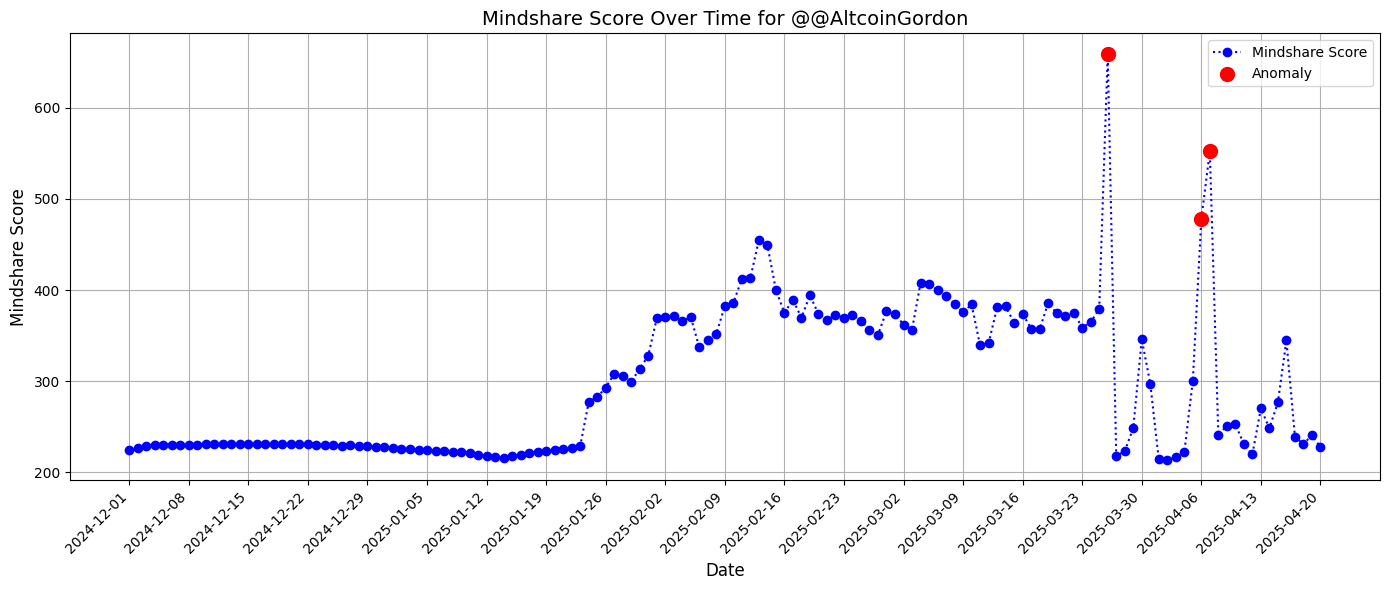

Mistral raw response: {"sentiment":"positive","insight":"This positive news about Ethereum's potential technical improvements and market indicators may drive increased optimism and attention towards the crypto market."}
Mistral raw response: {"sentiment":"positive","insight":"This positive news about the BNB Chain ecosystem's growth and BNB's upward trend may drive increased investor interest and market attention."}
Mistral raw response: {"sentiment":"positive","insight":"This positive news about NFT ecosystem activity and expansions may drive increased interest and investment in the crypto market."}
Mistral raw response: {"sentiment":"positive","insight":"This positive news about technological advancements and competition among blockchain platforms may drive increased interest and investment in the crypto market."}
Rate limit exceeded. Retrying in 5.0 seconds... (Attempt 1/3)
Mistral raw response: {"sentiment":"positive","insight":"This positive development in asset tokenization and i

In [52]:
# Analyze mindshare data for the handle "identifier"
result = analyze_mindshare_data("@AltcoinGordon")

# Display the result
import json
print(json.dumps(result, indent=2))